# Лабораторная работа №2.  Интерполяция временных рядов с помощью рекуррентных нейронных сетей.



## Цель работы

Изучение применения рекуррентных нейронных сетей (LSTM) для
интерполяции временных рядов в условиях зашумленных данных и сравнение их с
классическими методами.


##Вариант 2

Вариант 2: Интерполяция данных о COVID-19
Используем временные ряды с количеством заражений и смертей от COVID19. Цель — обучить модель, которая сможет интерполировать пропущенные
значения.
Шаги работы:
1. Загрузка данных:
- Скачать COVID-19 Dataset.
- Выбрать ключевые столбцы (Confirmed, Deaths, Recovered).
2. Предобработка данных:
- Привести даты к числовому формату.
- Искусственно удалить некоторые значения, чтобы проверить
интерполяцию.
- Добавить случайный шум к данным.
- Разделить данные на обучающую и тестовую выборки.
3. Обучение модели:
- Создать архитектуру LSTM для предсказания пропущенных значений.
- Обучить модель на зашумленных данных.
4. Тестирование:
- Сравнить качество интерполяции с классическими методами
(например, линейная интерполяция, сплайны).
- Оценить качество по метрикам MSE, MAE и R²

##Ход выполнения работы

 Загружаются библиотеки pandas для работы с датафреймами, numpy для работы с массивами и математическими операциями, а также tensorflow и keras для создания нейронных сетей. Также подключаются инструменты для предварительной обработки данных, такие как MinMaxScaler для масштабирования и train_test_split для разделения данных на обучающую и тестовую выборки. Для визуализации используется библиотека matplotlib.

Далее загружается датафрейм содержащий данные о COVID-19.

1. Date - дата записи.
2. Country/Region - страна или регион.
3. Province/State - провинция или штат.
4. Confirmed - количество  случаев заражения .
5. Deaths - количество смертельных случаев.
6. Recovered - количество людей, выздоровевших от болезни.
7. Active - количество активных случаев.
8. Population - численность населения региона.

Этот датафрейм содержит подробную информацию о распространении COVID-19 по различным регионам и датам, что позволяет анализировать тренды и паттерны заболевания, а также использовать данные для построения прогнозных моделей.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid_19_data.csv', sep=',')
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.00,0.00,0.00
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.00,0.00,0.00
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.00,0.00,0.00
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.00,0.00,0.00
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...
306424,306425,05/29/2021,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641.00,2335.00,95289.00
306425,306426,05/29/2021,Zeeland,Netherlands,2021-05-30 04:20:55,29147.00,245.00,0.00
306426,306427,05/29/2021,Zhejiang,Mainland China,2021-05-30 04:20:55,1364.00,1.00,1324.00
306427,306428,05/29/2021,Zhytomyr Oblast,Ukraine,2021-05-30 04:20:55,87550.00,1738.00,83790.00


Оставляются только нужные поля, также поле содержащее дату преобразовывается в формат даты.

In [ ]:
df = df[['ObservationDate', 'Confirmed', 'Deaths', 'Recovered']]
df.head()

,ObservationDate,Confirmed,Deaths,Recovered
0,01/22/2020,1.00,0.00,0.00
1,01/22/2020,14.00,0.00,0.00
2,01/22/2020,6.00,0.00,0.00
3,01/22/2020,1.00,0.00,0.00
4,01/22/2020,0.00,0.00,0.00


Далее данные группируются по датам, для дальнейшего предсказания полей по дате, для этого поле ObservationDate было преобразована в формат datetime

In [ ]:
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ObservationDate  306429 non-null  datetime64[ns]
 1   Confirmed        306429 non-null  float64       
 2   Deaths           306429 non-null  float64       
 3   Recovered        306429 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 9.4 MB


<ipython-input-72-f616aa43211c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])


In [ ]:
df = df.groupby('ObservationDate').sum().reset_index()
df

,ObservationDate,Confirmed,Deaths,Recovered
0,2020-01-22,557.00,17.00,30.00
1,2020-01-23,1097.00,34.00,60.00
2,2020-01-24,941.00,26.00,39.00
3,2020-01-25,1437.00,42.00,42.00
4,2020-01-26,2118.00,56.00,56.00
...,...,...,...,...
489,2021-05-25,167848207.00,3485788.00,104824935.00
490,2021-05-26,168416423.00,3498544.00,105380748.00
491,2021-05-27,168970791.00,3511297.00,106078106.00
492,2021-05-28,169470725.00,3523117.00,106633069.00


После дата преобразовывается в числовой формат

In [ ]:
df['ObservationDate'] = (df['ObservationDate'] - df['ObservationDate'].min()).dt.days
df

,ObservationDate,Confirmed,Deaths,Recovered
0,0,557.00,17.00,30.00
1,1,1097.00,34.00,60.00
2,2,941.00,26.00,39.00
3,3,1437.00,42.00,42.00
4,4,2118.00,56.00,56.00
...,...,...,...,...
489,489,167848207.00,3485788.00,104824935.00
490,490,168416423.00,3498544.00,105380748.00
491,491,168970791.00,3511297.00,106078106.00
492,492,169470725.00,3523117.00,106633069.00


Далее создается новый датафрейм, где к данным добавляется случайный шум

In [ ]:
df_noisy = df.copy()
num_outliers = 20

outlier_indices = np.random.choice(df.index, size=num_outliers, replace=False)

for idx in outlier_indices:
    for col in ['Confirmed', 'Deaths', 'Recovered']:
        change = np.random.uniform(-0.5, 0.5) * df_noisy.at[idx, col]
        df_noisy.at[idx, col] += change

df_noisy[['Confirmed', 'Deaths', 'Recovered']] = df_noisy[['Confirmed', 'Deaths', 'Recovered']].round().astype(int)
display(df_noisy.head(10))

,ObservationDate,Confirmed,Deaths,Recovered
0,0,557,17,30
1,1,1097,34,60
2,2,941,26,39
3,3,1437,42,42
4,4,2118,56,56
5,5,2927,82,65
6,6,5578,131,108
7,7,6165,133,127
8,8,8235,171,145
9,9,9925,213,225


Случайным образом выбираются 10% значений

In [ ]:
df_missing = df_noisy.copy()
missing_indices = np.random.choice(df_missing.index, size=int(len(df) * 0.1), replace=False)

Значения в полях Confirmed, Deaths, Recovered заполняются пропусками

In [ ]:
df_missing.loc[missing_indices, ['Confirmed', 'Deaths', 'Recovered']] = np.nan

In [ ]:
display(df.head(10))
display(df_missing.head())

,ObservationDate,Confirmed,Deaths,Recovered
0,0,557.00,17.00,30.00
1,1,1097.00,34.00,60.00
2,2,941.00,26.00,39.00
3,3,1437.00,42.00,42.00
4,4,2118.00,56.00,56.00
5,5,2927.00,82.00,65.00
6,6,5578.00,131.00,108.00
7,7,6165.00,133.00,127.00
8,8,8235.00,171.00,145.00
9,9,9925.00,213.00,225.00


,ObservationDate,Confirmed,Deaths,Recovered
0,0,557.00,17.00,30.00
1,1,1097.00,34.00,60.00
2,2,941.00,26.00,39.00
3,3,1437.00,42.00,42.00
4,4,2118.00,56.00,56.00


Далее данные разделяются на тестовую и тренировочную выборку, предварительно производится очистка от данных, которые содержать пропуски

In [ ]:
test_df_only_NaN = df.loc[missing_indices]
df_noisy_cleaned = df_noisy.drop(index=missing_indices)

train_df, test_df = train_test_split(df_noisy_cleaned, test_size=0.2)

После входные и выходные данные подготавливаются в качестве признаковы будут использованы поля Confirmed, Deaths и Recovered, а в качестве целевой переменной поле ObservationDate


In [ ]:
X_train = train_df[['Confirmed', 'Deaths', 'Recovered']].values
X_test = test_df[['Confirmed', 'Deaths', 'Recovered']].values
X_test_only_NaN = test_df_only_NaN[['Confirmed', 'Deaths', 'Recovered']].values

y_train = train_df[['ObservationDate']].values
y_test = test_df[['ObservationDate']].values
y_test_only_NaN = test_df_only_NaN[['ObservationDate']].values


 Далее данные масштабируются для того улучшить сходимость нейронной сети и повысить её производительность. 1.

In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)
X_test_only_NaN_scaled = scaler_X.transform(X_test_only_NaN)
y_test_only_NaN_scaled = scaler_y.transform(y_test_only_NaN)




Данные преобразовываются, чтобы подать их в модель LSTM. Для модели данные должны быть трехмерными. Первое измерение - кол-во признаков, второе з кол-во временных шагов, третье - колв-о признаков для каждого временного шага.
В итоге создастся трехмерный массив с размером (кол-во примеров, кол-во временных шагов, кол-во признаков)

In [ ]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
X_test_only_NaN_scaled = X_test_only_NaN_scaled.reshape(X_test_only_NaN_scaled.shape[0], 1, X_test_only_NaN_scaled.shape[1])

Далее создается модель, где каждый слой будет связан со следующий последовательно. В качестве функции активации выбрана tanh, которая регулирует значения, оставляя их в пром-ке от -1 до 1. return_sequences=True - означает,что мы возвращаем последовательность в случае с False возвращало бы последний выход, input_shape=(1, 3) указывает на форму, что мы имеем 1 временной шаг и 3 признака. Для предотвращения переобучения также были использованы слои Dropout. Выходной слой имеет 1 значений.

In [ ]:
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(1, 3)))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Далее модель компилируется с указание оптимизатора и функции потерь mse (среднеквадратичная ошибка)


In [ ]:
model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, verbose=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 1, 128)              │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.3016
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1847
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0684
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0128
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0163
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0114
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0097
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 13/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083
Epoch 14/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085
Epoch 15/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 

Далее визуализируются график, на рисунке видно, как с увеличение эпох уменьшается ошибка

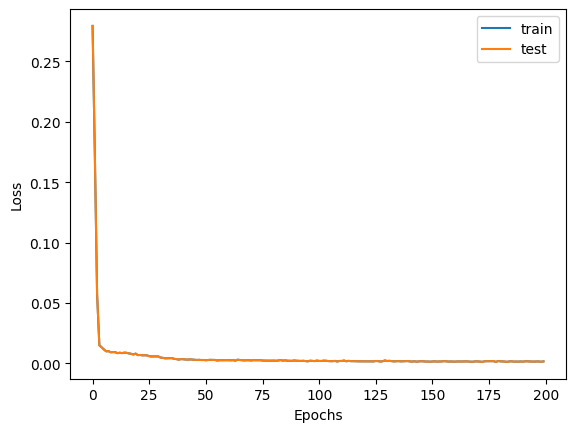

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['loss'], label='test')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Подсчитываются метрики:
- MSE -  измеряет среднее значение квадратов ошибок
- MAE -  средня величина ошибки в абсолютном значении между.
- r2_score -  коэффициент детерминации (R²), который измеряет, насколько близки предсказания к фактическим данным. 0 - Учи мат. часть, 1 - Очень хорошая модель.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test = scaler_y.inverse_transform(y_test_scaled)
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
MSE: 213.94543035224856
MAE: 9.544057781776685
R²: 0.9916449205348282


Далее осуществляется предсказание пропущенных значений в тестовых данных, где ранее были искусственно удалены значения.

In [ ]:
y_pred_scaled_only_NaN = model.predict(X_test_only_NaN_scaled)

y_pred_only_NaN = scaler_y.inverse_transform(y_pred_scaled_only_NaN)
y_test_only_NaN = scaler_y.inverse_transform(y_test_only_NaN_scaled)

pd.set_option('display.float_format', '{:.2f}'.format)

results = pd.DataFrame({
    'Дата наблюдения': test_df_only_NaN['ObservationDate'].values,
    'Confirmed': test_df_only_NaN['Confirmed'].values,
    'Deaths': test_df_only_NaN['Deaths'].values,
    'Recovered': test_df_only_NaN['Recovered'].values,
    'Истинные значения': y_test_only_NaN[:, 0],
    'Предсказанные значения': y_pred_only_NaN[:, 0],
})

print("Сравнение предсказанных и истинных значений:")
display(results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Сравнение предсказанных и истинных значений:


,Дата наблюдения,Confirmed,Deaths,Recovered,Истинные значения,Предсказанные значения
0,349,86546014.00,1875953.00,48488548.00,349.00,359.78
1,242,31101756.00,961312.00,21261177.00,242.00,250.80
2,119,4999275.00,329335.00,1897701.00,119.00,119.90
3,473,158330372.00,3293188.00,94371825.00,473.00,476.64
4,60,337867.00,14633.00,97225.00,60.00,46.18
5,197,19124996.00,715180.00,11546442.00,197.00,206.02
6,117,4805351.00,319807.00,1787121.00,117.00,117.74
7,154,9442922.00,482763.00,4746193.00,154.00,155.58
8,296,53566478.00,1305675.00,34481579.00,296.00,301.45
9,15,30818.00,634.00,1492.00,15.00,42.24


Для более наглядной работы модели данные визуализируются

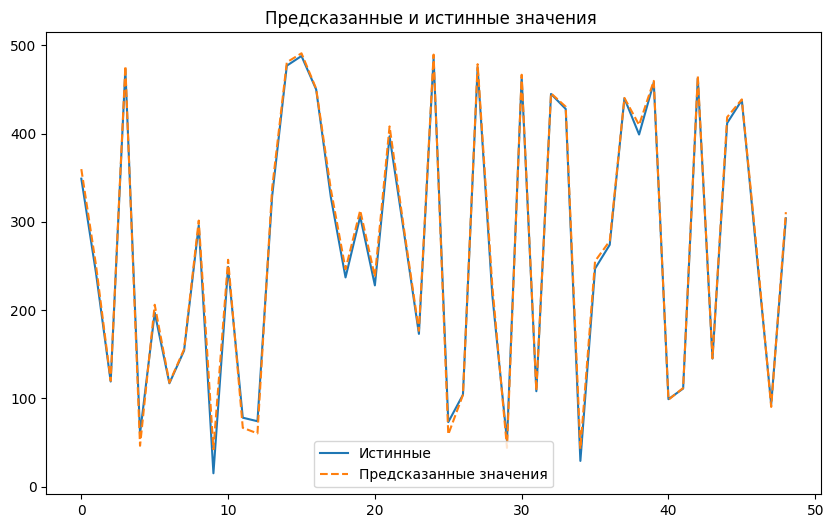

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(y_test_only_NaN, label='Истинные')

plt.plot(y_pred_only_NaN, label='Предсказанные значения', linestyle='dashed')

plt.legend()
plt.title('Предсказанные и истинные значения ')
plt.show()


Далее создается функция которая считает метрики для линейной и сплайновой интерполяции

In [ ]:
def interpolate_and_evaluate(df_missing, df_noisy, method='linear', order=3, scaler_y=None):
    if method == 'linear':
        df_interpolated = df_missing.interpolate(method='linear')
    elif method == 'spline':
        df_interpolated = df_missing.interpolate(method='spline', order=order)
    else:
        raise ValueError("Метод интерполяции должен быть 'linear' или 'spline'")

    df_interpolated = df_interpolated.dropna(subset=['Confirmed', 'Deaths', 'Recovered'])
    cleaned_indices = df_interpolated.index
    y_true = df_noisy.loc[cleaned_indices, ['Confirmed', 'Deaths', 'Recovered']].values
    y_pred = df_interpolated.loc[cleaned_indices, ['Confirmed', 'Deaths', 'Recovered']].values
    y_true_scaled = scaler_y.fit_transform(y_true)
    y_pred_scaled = scaler_y.transform(y_pred)
    mse = mean_squared_error(y_true_scaled, y_pred_scaled)
    mae = mean_absolute_error(y_true_scaled, y_pred_scaled)
    r2 = r2_score(y_true_scaled, y_pred_scaled)
    print(f'{method.capitalize()} Interpolation MSE: {mse}')
    print(f'{method.capitalize()} Interpolation MAE: {mae}')
    print(f'{method.capitalize()} Interpolation R²: {r2}')

linear_metrics = interpolate_and_evaluate(df_missing, df_noisy, method='linear', scaler_y=scaler_y)
spline_metrics = interpolate_and_evaluate(df_missing, df_noisy, method='spline', order=3, scaler_y=scaler_y)



Linear Interpolation MSE: 5.39183591539888e-05
Linear Interpolation MAE: 0.0005761478742212669
Linear Interpolation R²: 0.9993437457479852
Spline Interpolation MSE: 9.756223116207182e-05
Spline Interpolation MAE: 0.0009178633082896605
Spline Interpolation R²: 0.9987984249805634


/usr/local/lib/python3.11/dist-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)



Линейная и сплайновая интерполяция значительно превосходят модель по точности. Методы интерполяции подходят для восстановления пропущенных значений с гораздо меньшими ошибками. Возможно, потребуется улучшить модель или попробовать другие подходы для предсказания, чтобы достичь более низких ошибок.

# Вывод
В ходе выполнения лабораторной работы был изучен метод интерполяции временных рядов с помощью рекуррентных нейронных сетей (LSTM) и классических методов, таких как линейная и сплайновая интерполяция. Линейная и сплайновая интерполяция показали очень хорошие результаты с минимальными ошибками и коэффициентом детерминации R² близким к 1. Модель LSTM, хоть и дала хорошие результаты на зашумленных данных, показала несколько более высокие ошибки по сравнению с классическими методами.

Результаты показали, что для линейных данных классические методы интерполяции более точны и просты в применении. Модель LSTM может быть полезна для более сложных временных рядов с нелинейными зависимостями, где классические методы могут не справиться.